In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Image Augmentation




In [ ]:
import albumentations as A
images_to_generate=10


images_path='/content/drive/My Drive/drive/menbrain/train/' #path to original images
masks_path = '/content/drive/My Drive/drive/menbrain/label/'
img_augmented_path='/content/drive/My Drive/drive/menbrain/augmented_train/' # path to store aumented images
msk_augmented_path='/content/drive/My Drive/drive/menbrain/augmented_label/' # path to store aumented images
images=[] # to store paths of images from folder
masks=[]

for im in sorted(os.listdir(images_path)):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

for msk in sorted(os.listdir(masks_path)):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))


aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=1)
    ]
)

random.seed(42)

for j in range(len(images)):
    for i in range(images_to_generate): 
          #number = random.randint(0, len(images)-1)  #PIck a number to select an image & mask
          image = images[j]
          mask = masks[j]
          #print(image, mask)
          #image=random.choice(images) #Randomly select an image name
          original_image = io.imread(image)
          original_mask = io.imread(mask)
          
          augmented = aug(image=original_image, mask=original_mask)
          transformed_image = augmented['image']
          transformed_mask = augmented['mask']

              
          new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i+(j*images_to_generate))
          new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i+(j*images_to_generate))
          io.imsave(new_image_path, transformed_image)
          io.imsave(new_mask_path, transformed_mask)

In [2]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import cv2
import glob


In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
img = imread("/content/drive/My Drive/drive/menbrain/augmented_train/augmented_image_1.png")

In [5]:
img.shape

(512, 512)

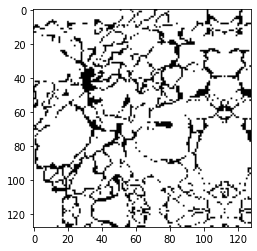

In [41]:
plt.imshow(train_masks[1], cmap='gray')

In [43]:
train_images = []

for directory_path in glob.glob("/content/drive/My Drive/drive/menbrain/augmented_train"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
      
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/drive/My Drive/drive/menbrain/augmented_label"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [44]:
train_masks[train_masks>0] = 1.0


In [26]:
train_masks[train_masks<=100] = 0


In [12]:
train_images.shape

(300, 128, 128, 3)

In [66]:
np.unique(train_masks[0])

array([0, 1], dtype=uint8)

In [47]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_38[0][0]                  
____________________________________________________________________________________________

In [48]:
x = train_images
y = train_masks
y = np.expand_dims(y, 3)

In [16]:
y.shape

(300, 128, 128, 1)

In [69]:
earlystopper = EarlyStopping(patience=5, verbose=1)
#checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
model.fit(x, y, validation_split=0.1, batch_size=32, epochs=60)

Epoch 1/60
9/9 [==============================] - 1s 84ms/step - loss: 0.2907 - accuracy: 0.8670 - val_loss: 0.2825 - val_accuracy: 0.8711
Epoch 2/60
9/9 [==============================] - 1s 74ms/step - loss: 0.2871 - accuracy: 0.8690 - val_loss: 0.2930 - val_accuracy: 0.8671
Epoch 3/60
9/9 [==============================] - 1s 75ms/step - loss: 0.2918 - accuracy: 0.8667 - val_loss: 0.2855 - val_accuracy: 0.8709
Epoch 4/60
9/9 [==============================] - 1s 74ms/step - loss: 0.2861 - accuracy: 0.8698 - val_loss: 0.2858 - val_accuracy: 0.8697
Epoch 5/60
9/9 [==============================] - 1s 74ms/step - loss: 0.2833 - accuracy: 0.8716 - val_loss: 0.2798 - val_accuracy: 0.8728
Epoch 6/60
9/9 [==============================] - 1s 75ms/step - loss: 0.2811 - accuracy: 0.8725 - val_loss: 0.2793 - val_accuracy: 0.8729
Epoch 7/60
9/9 [==============================] - 1s 75ms/step - loss: 0.2800 - accuracy: 0.8733 - val_loss: 0.2849 - val_accuracy: 0.8732
Epoch 8/60
9/9 [===========

In [53]:
img = np.expand_dims(pred, axis=0)

In [26]:
img.shape

(1, 128, 128, 3)

In [70]:
pred = model.predict(x)

In [ ]:
model.evaluate(x,y)

10/10 [==============================] - 0s 17ms/step - loss: 0.3397 - accuracy: 0.8254


[0.3397011160850525, 0.8254317045211792]

In [71]:
pred_1 = np.squeeze(pred[1])

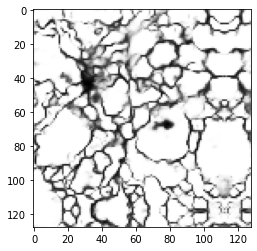

In [72]:
plt.imshow(pred_1, cmap='gray')

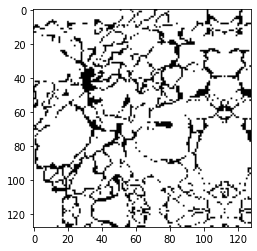

In [67]:
plt.imshow(np.squeeze(y[1]), cmap='gray')